In [1]:
import jax.numpy as np
import jax.ops
from jax import grad, jit
from functools import partial

In [37]:
data = np.load('data/HOOH.DFT.PBE-TS.light.MD.500K.50k.R_E_F_D_Q.npz')
X = np.array(data['R'][:20])
y = np.array(data['D'][:20])

In [3]:
def fill_diagonal(a, value):
    return jax.ops.index_update(a, np.diag_indices(a.shape[0]), value)

def descriptor(x):
    distances = np.sum((x[:, None] - x[None, :])**2, axis=-1)
    distances = fill_diagonal(distances, 1) # because sqrt fails to compute gradient if called on 0s
    distances = np.sqrt(distances)
    D = 1 / distances
    D = np.tril(D)
    D = fill_diagonal(D, 0)
    return D.flatten()

In [4]:
jit_descriptor = jit(descriptor)
x = X[0]
%timeit descriptor(x)
%timeit jit_descriptor(x)

6.59 ms ± 537 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)
125 µs ± 16.7 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [5]:
def gaussian(x, x_, sigma=1):
    d, d_ = jit(descriptor)(x), jit(descriptor)(x_)
    sq_distance = np.sum((d - d_)**2)
    return np.exp(-sq_distance / sigma)
    

In [6]:
_gaussian = partial(gaussian, X[0])
%timeit jit(_gaussian)(X[1])

1.23 ms ± 39.7 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


pure 17.3 ms

with jitted desc 2.52 ms

only jitted, desc normal 1.52 ms 

whole jitted 1.46 ms

In [8]:
from jax import jacfwd, jacrev
def hessian(f):
    return jacfwd(jacrev(f))

In [9]:
from jax.config import config
config.update("jax_debug_nans", True)

In [10]:
_gaussian = partial(gaussian, X[0])
hess = hessian(_gaussian)
hess(X[1]).shape

(4, 3, 4, 3)

In [11]:
def hess_ij(hess, x):
    H = hess(x)
    K = np.zeros((3, 3))
    for i in range(3):
        for j in range(3):
            value = np.sum(H[:, i, :, j])
            K = jax.ops.index_update(K, jax.ops.index[i, j], value)
    return K

In [12]:
k = hess_ij(hess, X[1])
k.shape

(3, 3)

In [13]:
def kernel(x, x_, sigma=1):
    _gaussian = partial(gaussian, x, sigma=sigma)
    hess = hessian(_gaussian)
    return hess_ij(hess, x_)

In [14]:
def kernel_matrix(X, sigma=1):
    samples = X.shape[0]
    K = np.zeros((samples, samples, 3, 3))
    K = list()
    for i in range(samples):
        K.append(list())
        for j in range(samples):
            K[i].append(kernel(X[i], X[j], sigma=sigma))
    K = np.block(K)
    return K

In [15]:
K = kernel_matrix(X[:10])

In [16]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

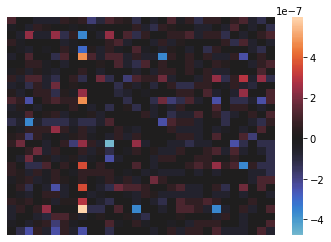

In [17]:
ax = sns.heatmap(K, center=0, xticklabels=False, yticklabels=False)
plt.show()

In [38]:
K = fill_diagonal(K, K.diagonal() + 1e-15)
samples = 10
y_ = y[:10].reshape(samples * 3)
alphas = np.linalg.solve(K, y_)
alphas = alphas.reshape(10, 3)

In [39]:
def predict(x, samples=samples, X=X, alphas=alphas):
    mu = np.zeros(3)
    for i in range(samples):
        mu += kernel(x, X[i]) @ alphas[i]
    return mu

In [42]:
y = y[:10].reshape(10, 3)
print(predict(X[9]))
print(y[9])

[ 0.04606366 -0.28939655 -0.55828404]
[ 0.04606372 -0.28939605 -0.5582838 ]


In [21]:
from jax import vmap, jit
vec_predict = vmap(predict)
jit_predict = jit(predict)

In [22]:
%timeit predict(X[10])
%timeit jit_predict(X[10])

617 ms ± 91.9 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
1.43 ms ± 109 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [54]:
k = jit(kernel_matrix)
%timeit -r1 -n1 k(X[:5])

49.3 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [23]:
# 10: 1.15
# 20: 

In [24]:
from utils import KRR

class VectorValuedKRR(KRR):

    def fit(self, X, y):
        self.X = X
        samples = X.shape[0]
        K = kernel_matrix(X, sigma=self.sigma)
        y = y.reshape(samples * 3)
        K = fill_diagonal(K, K.diagonal() + self.lamb)
        alphas = np.linalg.solve(K, y)
        self.alphas = alphas.reshape(samples, 3)

    def predict(self, x):
        results = [predict(_x, samples=self.samples, X=self.X, alphas=self.alphas) for _x in x]
        return np.array(results)

    def score(self, x, y):
        yhat = self.predict(x)
        return -np.mean(np.sum(np.abs(y - yhat), axis=1))

In [25]:
model = VectorValuedKRR()
model.fit(X[:10], y[:10])


In [26]:
results = model.score(X[10:20], y[10:20])
results

TypeError: sub got incompatible shapes for broadcasting: (0, 3), (10, 3).

In [36]:
# print(model.predict(X[10:11]))
print(y)

[[ 0.06685546 -0.3067279  -0.58624345]
 [ 0.06524433 -0.3048814  -0.58123165]
 [ 0.06434925 -0.3018499  -0.5770628 ]
 [ 0.06192087 -0.29949063 -0.5763836 ]
 [ 0.05752761 -0.29841384 -0.57824755]
 [ 0.05324033 -0.29768905 -0.57854253]
 [ 0.04974571 -0.29652625 -0.57563823]
 [ 0.04678717 -0.2946883  -0.57071954]
 [ 0.04516485 -0.29223508 -0.5648453 ]
 [ 0.04606372 -0.28939605 -0.5582838 ]]
